# Sleep stage classification on Sleep-edf data set

In this project, we will use deep neural network on raw EEG data for sleep stage classification.

This work is based on the MNE-Python and the mne-torch repository, as well as

Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., & Gramfort, A. (2018). A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4), 758-769.

# Sleep staging

The method of determining a person's sleep stage by studying their EEG and other physiological signs is known as sleep staging. Sleep recordings are generally separated into 30-second windows, with each window assigned to one of five groups ("stages"): <br>
**1) W: wakefulness**
**2) N1: light sleep**
**3) N2: deeper sleep**
**4) N3: deep sleep**
**5) R: rapid eye movement**
<br>

Sleep staging often relies on collecting changes in the EEG's spectral features as well as transitory events (such as sleep spindles, k-complexes, slow waves, and so on) that occur throughout various sleep phases.

We'll train a Deep neural network to conduct sleep staging on unseen raw EEG in this work. The Sleep Physionet dataset will be used, which comprises 153 nightly sleep recordings from 78 people. These recordings were carefully staged by sleep specialists, giving us the categorization objectives we needed to train and assess our ConvNet on

Identify whether a CUDA-enabled GPU is available

In [352]:

import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')
    

CUDA-enabled GPU found.


# Install required packages if not installed
!pip install mne <br>
!pip install torch <br>
!pip install matplotlib <br>
!pip install scikit-learn <br>
!pip install pandas <br>

In [360]:
# import modules
import os
import copy

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline



# enable GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Dataset
Importing the Sleep Physionet dataset's raw EEG recordings

In [61]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

subjects, recordings = range(83), [1, 2]

fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')
mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [81]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        max_time = (raw.n_times - 1) / raw.info['sfreq']
        #print(max_time)
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        if tmin >= 0 and tmax <= max_time:   # data preprocessing removing tmax (%s) which are grater than or equal to the max 
            raw.crop(tmin=tmin, tmax=tmax)
        else:
            pass
            
    
        
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

In [82]:
#data_loading

raws=[load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

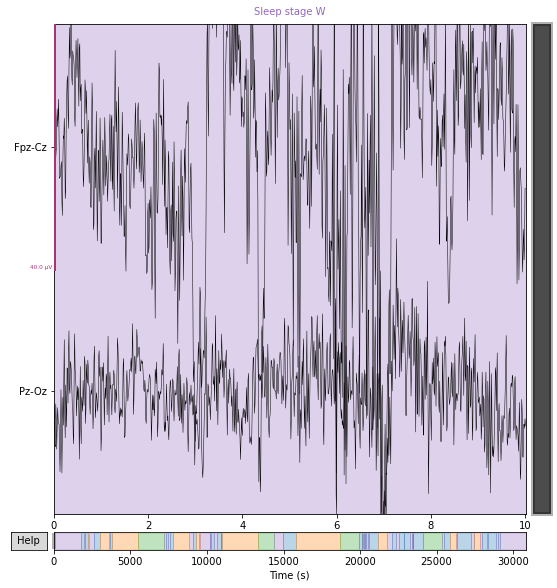

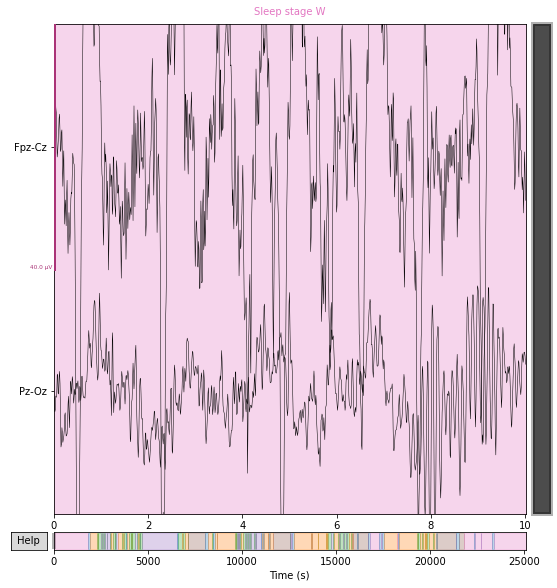

In [393]:
# Plot a recording as a sanity check
raws[135].plot();
raws[0].plot();

The Bar at the bottom have a different color and these color encoded for different sleep stages that were tagged by the sleep experts

## Preprocessing raw data

here we preprocess the raw data using a simple filtering step, followed by the extraction of 30-s windows.
<br>
The majority of the significant information in sleep EEG data is found below 30 Hz. As a result, we add a lowpass filter with a cutoff frequency of 30 Hz to our recordings to reduce the influence of higher frequency noise.



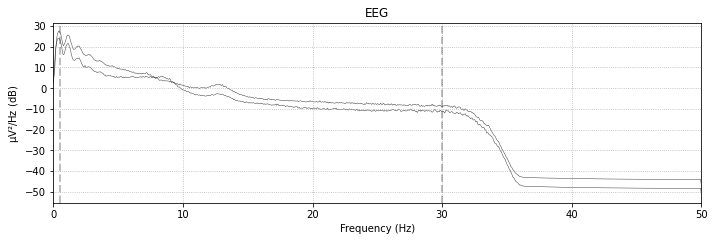

In [97]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place


# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

We can observe from the power spectral density figure that the filter has effectively filtered off the majority of the power over 30 Hz.
<br>
Fruther we will extract the extract the epochs that are 30 sec segments of the data that belongs to specific sleep stage


In [98]:
# function to extract 30-s windows

def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [99]:
#wrap arounfd around pytorch dataset class
from torch.utils.data import Dataset, ConcatDataset

class EpochsDataset(Dataset):
    """Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self,epochs_data, epochs_labels, subj_nb=None, rec_nb=None, transform =None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data =epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform
    def __len__(self):
        return len(self.epochs_labels)
    def __getitem__(self,idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

Removing dataset for which No matching events found for Sleep stage. So total 135 

In [211]:
raws_exc=[raws[40], raws[63], raws[65],raws[66],raws[67],raws[68],
          raws[109],raws[123],raws[124],raws[144]] # No matching events found for Sleep stage 3/4 (event id 4) [ removing from dataset]
raws_exc = raws_exc + [raws[x] for x in range(134,142)]

# 135
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
                for raw in raws if raw not in raws_exc]


# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

## Train, valid and test splits
Now we can Split  preprocessed and windowed data into three different sets (1): **Training set** is used to train and learn the neural network parameters, (2)  **validation set** is used for hyperparameter tuning and used to monitor the training process and decide when to stop.and (3) the **test set** is used to provide an estimate of the generalization performance of our model.

In [225]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """
    pick_idx = []
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
                
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None
    
    return pick_ds, remaining_ds
    

def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [213]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(123)
np.random.seed(123)

In [228]:
# Use recording 1 of subjects 0-19 as test set
test_recs = [(subj_nb, rec_nb)  #
             for subj_nb, rec_nb in zip(range(20), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [229]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')


Number of examples in each set:
Training: 112908
Validation: 43757
Test: 9850


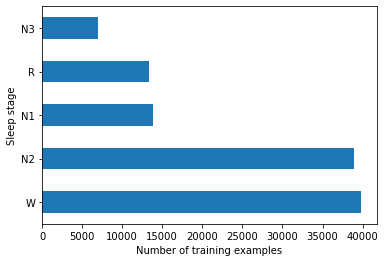

In [447]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

As we can see that the classes are imbalanced, i.e., There are lots of more classes for W and N2. These are more prevalent than the other sleep stages during the night:
<br>
one technique to account for this imbalance during training is to assign greater weight to samples from uncommon or rarer classes when computing the loss.The weights are calculated as follows:

In [448]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.56749095 1.62399137 0.58069792 3.23425952 1.69251986]


## Deep neural network
Here we will use deep network architecture to perform sleep stage classification from multivariate time series without temporal context 
has three key features: linear spatial filtering to estimate so called virtual channels, convolutive layers to capture spectral features and separate pipelines.
<br>
The first layer of the network implements a spatial filtering and it is a time-independent linear operation that outputs a set of virtual channels.
<br>
Then two blocks of temporal convolution followed by non-linearity and max pooling are consecutively applied

The sleep staging architecture is taken from Chambon et al. (2018), and the following figure is adapted from Banville et al. 2020:
<br>
**Chambon et al. (2018):** Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., & Gramfort, A. (2018). A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4), 758-769.
<br>
**Banville et al. 2020:** Banville, Hubert, et al. "Uncovering the structure of clinical EEG signals with self-supervised learning." Journal of Neural Engineering 18.4 (2021): 046020.

![convnet](convnet.png "SleepStagerChambon2018")

In [452]:

from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [453]:
# hyperperameters
dropout=0.75
lr=1e-3


In [454]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5,dropout=dropout)

In [455]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cuda'.


## Train deep neural network
Using Pytorch dataloader will load the data in baches to feed into neural network.

In [456]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 250  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [457]:
# functions to carry out our training and validation loops:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = [], []
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = [], []
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = []
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [458]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [459]:
n_epochs = [ 10, 
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.0658 	 0.8147 	 0.4031 	 0.5594
best val loss inf -> 0.8147
2 	 0.9126 	 0.7147 	 0.5212 	 0.6477
best val loss 0.8147 -> 0.7147
3 	 0.8635 	 0.6541 	 0.5456 	 0.6519
best val loss 0.7147 -> 0.6541
4 	 0.8258 	 0.6701 	 0.5605 	 0.6427
5 	 0.8059 	 0.5983 	 0.5651 	 0.6959
best val loss 0.6541 -> 0.5983
6 	 0.8002 	 0.6461 	 0.5677 	 0.6829
7 	 0.7917 	 0.6257 	 0.5709 	 0.6479
8 	 0.7881 	 0.6174 	 0.5713 	 0.6979
9 	 0.7804 	 0.6129 	 0.5714 	 0.6677
10 	 0.7753 	 0.6187 	 0.5745 	 0.6700
Stop training at epoch 10
Best val loss : 0.5983


Text(0, 0.5, "Cohen's kappa")

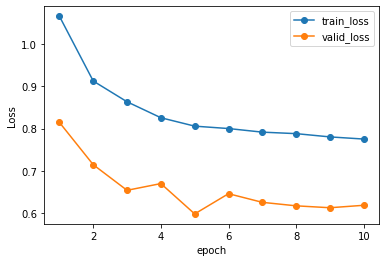

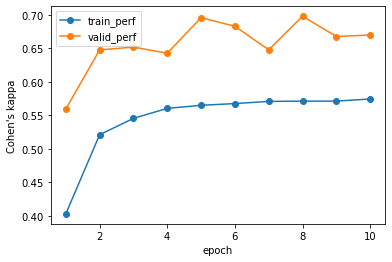

In [460]:
# Visualizing the learning curves

history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')

In [461]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = [], []
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.762
Test Cohen's kappa: 0.692


In [462]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = [key for key in classes_mapping.keys()]
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()
    
    return fig, ax

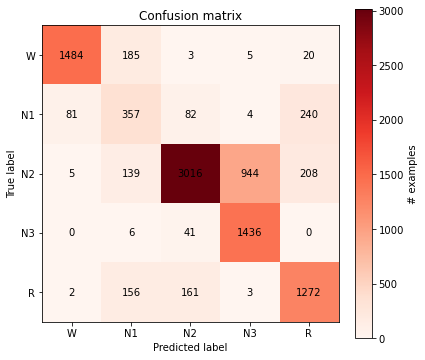

In [463]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

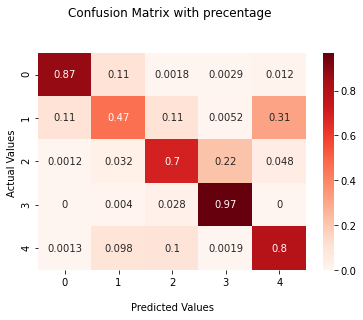

In [464]:
import seaborn as sns

ax = sns.heatmap(conf_mat/conf_mat.sum(axis=1)[:, np.newaxis], annot=True,  cmap='Reds')

ax.set_title('Confusion Matrix with precentage \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()

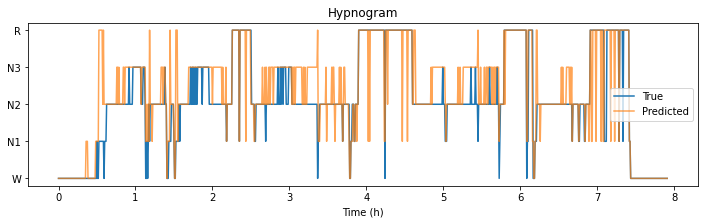

In [465]:
# Plot hypnogram for one recording

mask = rec_ids == 3  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend();